In [ ]:
!pip install kaggle

In [ ]:

from google.colab import files
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username": "AbinayaB04", "key": "KGAT_ceec7b63217294cd9e537d0a9135b5e3"}'}

In [ ]:
import os

In [ ]:
os.makedirs('/root/.kaggle',exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images


Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 72% 75.0M/105M [00:00<00:00, 780MB/s]
100% 105M/105M [00:00<00:00, 787MB/s] 


In [ ]:
import zipfile
with zipfile.ZipFile('cifake-real-and-ai-generated-synthetic-images.zip', 'r') as zip_ref:
    zip_ref.extractall('./cifake')

In [ ]:
for root, dirs, files in os.walk('./cifake'):
  level=root.replace('./cifake','').count(os.sep)
  indent=' '*2*level
  print(f'{indent}{os.path.basename(root)}/')
  if level==2:
    print(f'{indent}--> {len(files)} images')

cifake/
  test/
    REAL/
    --> 10000 images
    FAKE/
    --> 10000 images
  train/
    REAL/
    --> 50000 images
    FAKE/
    --> 50000 images


In [ ]:
import torch
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split

In [ ]:
train_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.3,0.3,0.3])
])

test_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.3,0.3,0.3])
]
)

In [ ]:
#loading dataset
DATA_DIRECTORY='./cifake'
train_dataset=datasets.ImageFolder(root=f'{DATA_DIRECTORY}/train',transform=train_transform)
test_dataset=datasets.ImageFolder(root=f'{DATA_DIRECTORY}/test',transform=test_transform)
print(f"Classes:{train_dataset.classes}")
print(f"Classes to index:{train_dataset.class_to_idx}")


Classes:['FAKE', 'REAL']
Classes to index:{'FAKE': 0, 'REAL': 1}


In [ ]:
#train val split
train_size=int(0.9*len(train_dataset))
val_size=len(train_dataset)-train_size
train_data,val_data=random_split(train_dataset,[train_size,val_size],generator=torch.Generator().manual_seed(42))
print(f"Train size:{len(train_data)}")
print(f"Val size:{len(val_data)}")
print(f"Test size:{len(test_dataset)}")

Train size:90000
Val size:10000
Test size:20000


In [ ]:
BATCH_SIZE=64
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)
val_loader=DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
images,labels=next(iter(train_loader))
print(f"Image batch shape : {images.shape}")     # (64, 3, 32, 32)
print(f"Label batch shape : {labels.shape}")     # (64,)
print(f"Unique labels     : {labels.unique()}")  # tensor([0, 1])

Image batch shape : torch.Size([64, 3, 32, 32])
Label batch shape : torch.Size([64])
Unique labels     : tensor([0, 1])


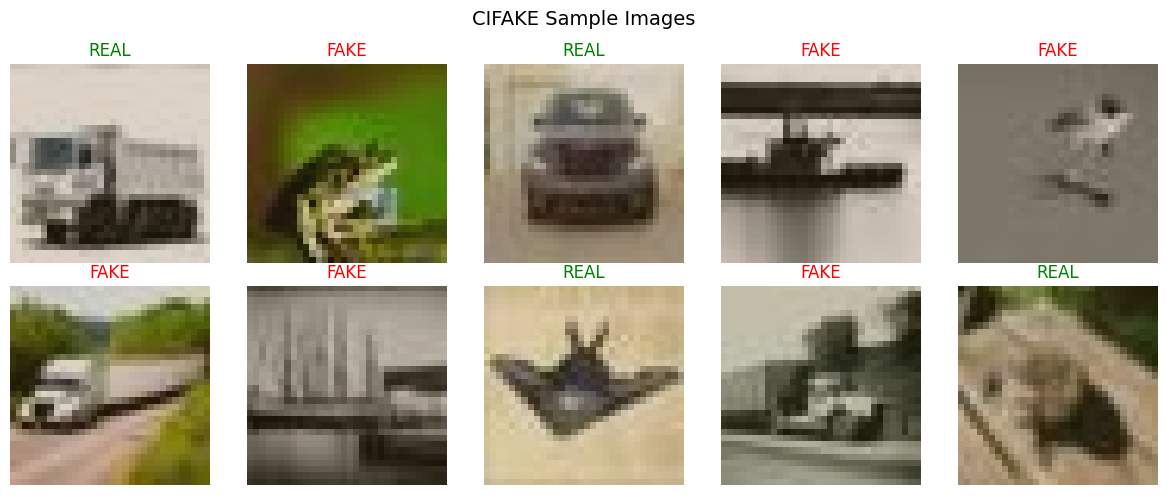

In [ ]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (tensor * std + mean).clamp(0, 1)

# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAKE Sample Images', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    label = train_dataset.classes[labels[i]]
    ax.imshow(img)
    ax.set_title(label, color='green' if label == 'REAL' else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import Subset, DataLoader
import random, numpy as np, copy
from torch.backends import cudnn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, RocCurveDisplay,
                             precision_recall_curve, average_precision_score, PrecisionRecallDisplay)

# Reproducibility
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Setup DataPaths (Matching your Kaggle input)
#loading dataset
DATA_DIRECTORY='./cifake'
train_path=f'{DATA_DIRECTORY}/train'
test_path=f'{DATA_DIRECTORY}/test'

# Use the exact transforms defined in your earlier cells
resnet_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

# Load and Split Datasets
training_data = datasets.ImageFolder(root=train_path, transform=resnet_transform)
testing_data  = datasets.ImageFolder(root=test_path, transform=resnet_transform)

trainingSize = 80000
indices = list(range(len(training_data)))
random.shuffle(indices)

train_Indices = indices[:trainingSize]
val_Indices   = indices[trainingSize:]

newTraining_Data = Subset(training_data, train_Indices)
validation_Data  = Subset(training_data, val_Indices)

train_loader_res = DataLoader(newTraining_Data, batch_size=64, shuffle=True, num_workers=2)
val_loader_res   = DataLoader(validation_Data, batch_size=64, shuffle=False, num_workers=2)
test_loader_res  = DataLoader(testing_data, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# 1. Load Pretrained ResNet-50
num_classes = 2 # FAKE and REAL
model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# 2. Fine-tuning strategy: Freeze all but layer4 and fc
for name, param in model_resnet.named_parameters():
    if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False

# 3. Replace final layer
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, num_classes)
model_resnet = model_resnet.to(device)

# 4. Define Training Function (Named correctly to match your call)
def train_resnet(model, train_loader, val_loader, epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=1e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        run_loss, preds, labels = 0.0, [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * x.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            labels.extend(y.cpu().tolist())

        # Validation phase
        model.eval()
        v_preds, v_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                v_preds.extend(out.argmax(1).cpu().tolist())
                v_labels.extend(y.cpu().tolist())

        val_acc = accuracy_score(v_labels, v_preds)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "best_resnet_cifake.pth")

    model.load_state_dict(best_model_wts)
    return model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
print("Starting ResNet Fine-tuning...")
model_resnet = train_resnet(model_resnet, train_loader_res, val_loader_res, epochs=5)

Starting ResNet Fine-tuning...
Epoch 1/5 | Val Acc: 0.9182
Epoch 2/5 | Val Acc: 0.9244
Epoch 3/5 | Val Acc: 0.9318
Epoch 4/5 | Val Acc: 0.9274
Epoch 5/5 | Val Acc: 0.9316


Evaluating ResNet-50 on test data...

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        FAKE       0.94      0.92      0.93     10000
        REAL       0.92      0.94      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



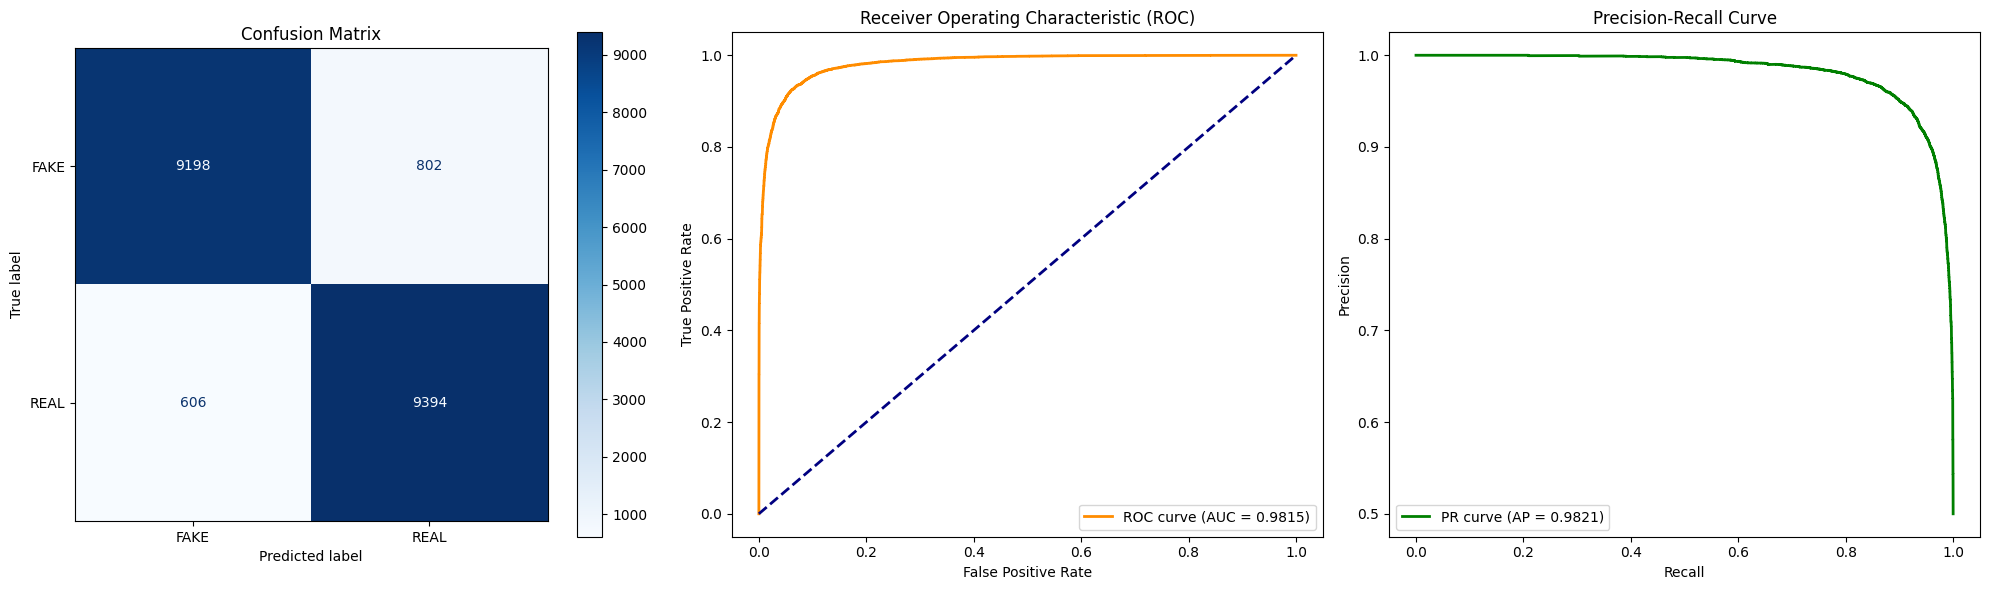

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

# 1. Generate Predictions for the Test Set
model_resnet.eval()
all_preds = []
all_labels = []
all_probs = []

print("Evaluating ResNet-50 on test data...")
with torch.no_grad():
    for x, y in test_loader_res:
        x, y = x.to(device), y.to(device)
        outputs = model_resnet(x)

        # Get probabilities for the 'REAL' class (index 1)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs[:, 1].cpu().numpy())
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 2. Print Classification Metrics
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(all_labels, all_preds, target_names=["FAKE", "REAL"]))

# 3. Plot Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])
disp.plot(cmap='Blues', ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix')

# 4. Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].legend(loc="lower right")

# 5. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap_score = average_precision_score(all_labels, all_probs)
ax[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve')
ax[2].legend(loc="lower left")

plt.tight_layout()
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import cv2 # Used to stretch the heatmap to 32x32

# --- Keep your function exactly as it is ---
def generate_gradcam(model, input_batch, target_layer):
    model.eval()
    feature_gradients = []
    feature_activations = []

    def save_gradient(grad):
        feature_gradients.append(grad)

    handle_act = target_layer.register_forward_hook(lambda m, i, o: feature_activations.append(o))
    handle_grad = target_layer.register_full_backward_hook(lambda m, i, o: save_gradient(o[0]))

    output = model(input_batch)
    target_class = output.argmax(dim=1)

    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1
    output.backward(gradient=one_hot)

    grads = feature_gradients[0].cpu().data.numpy()
    acts = feature_activations[0].cpu().data.numpy()

    weights = np.mean(grads, axis=(2, 3))[0]
    cam = np.zeros(acts.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[0, i, :, :]

    cam = np.maximum(cam, 0)
    if np.max(cam) > 0:
        cam = cam / np.max(cam)

    handle_act.remove()
    handle_grad.remove()
    return cam, target_class.item()

# --- NEW: Interactive UI Setup ---
index_slider = widgets.IntSlider(value=0, min=0, max=len(testing_data)-1, description='Image ID:')
run_button = widgets.Button(description="Explain Image", button_style='info')
output_area = widgets.Output()

def run_explanation(b):
    with output_area:
        clear_output(wait=True)

        # Get selected image
        idx = index_slider.value
        sample_img, sample_label = testing_data[idx]
        input_tensor = sample_img.unsqueeze(0).to(device)

        # Generate CAM
        cam, pred_idx = generate_gradcam(model_resnet, input_tensor, model_resnet.layer4[-1])

        # Resize CAM to match image size (32x32)
        cam_resized = cv2.resize(cam, (32, 32))

        # Plotting
        plt.figure(figsize=(10, 5))

        # Left: Original
        plt.subplot(1, 2, 1)
        plt.title(f"Actual Label: {testing_data.classes[sample_label]}")
        plt.imshow(denormalize(sample_img).permute(1, 2, 0))
        plt.axis('off')

        # Right: Grad-CAM Overlay
        plt.subplot(1, 2, 2)
        plt.title(f"Model Prediction: {testing_data.classes[pred_idx]}")
        # Show original image first
        plt.imshow(denormalize(sample_img).permute(1, 2, 0))
        # Overlay heatmap with transparency (alpha)
        plt.imshow(cam_resized, cmap='jet', alpha=0.5)
        plt.axis('off')

        plt.show()

run_button.on_click(run_explanation)

# Display the widgets
display(widgets.VBox([widgets.HBox([index_slider, run_button]), output_area]))